In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps

from scipy.signal import find_peaks


In [2]:
data_src = r"D:\Data\both 800fps\brightfield\*tif"

In [3]:
data = OG.SequenceManager.load_tif(data_src)

Setting source to D:\Data\both 800fps\brightfield\*tif
Getting reference sequence
Reference period: 306.2209554777414; Reference indices: [111, 422]
Getting SADs
Getting phases


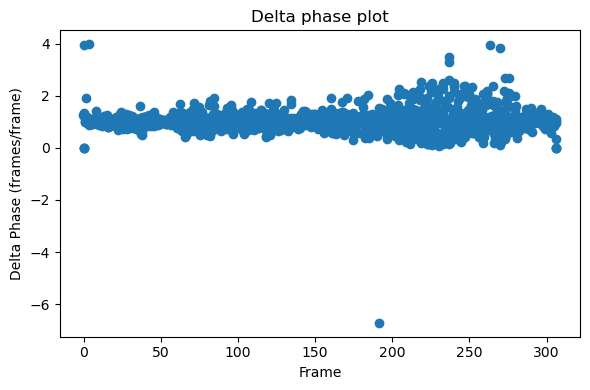

In [4]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(data_src)
oog.settings["pi_space"] = False
oog.settings["include_reference_frames"] = True
oog.run()

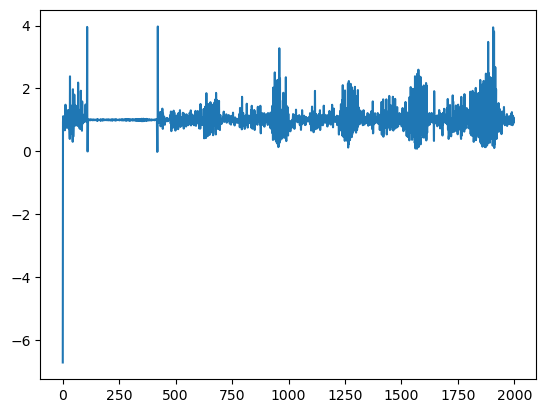

In [5]:
plt.plot(oog.delta_phases)

In [6]:
# Gets the noise spectrum by looking at the standard deviation of the change in delta phases over some time period.
def get_noise_spectrum(delta_phases, averaging_window):
    time_windows = range(1, (delta_phases.shape[0] - averaging_window) // 2)
    avg_delta_phases_std = []
    for time_window in time_windows:
        avg_delta_phases = []
        for i in np.arange(delta_phases.shape[0] - time_window - averaging_window):
            average_delta_phase_init = np.mean(delta_phases[i:i + averaging_window])
            average_delta_phase_final = np.mean(delta_phases[i + time_window:i + time_window + averaging_window])

            est_avg_delta_phases = average_delta_phase_init - average_delta_phase_final

            avg_delta_phases.append(est_avg_delta_phases)

        avg_delta_phases_std.append(np.std(avg_delta_phases))

    return time_windows, avg_delta_phases_std

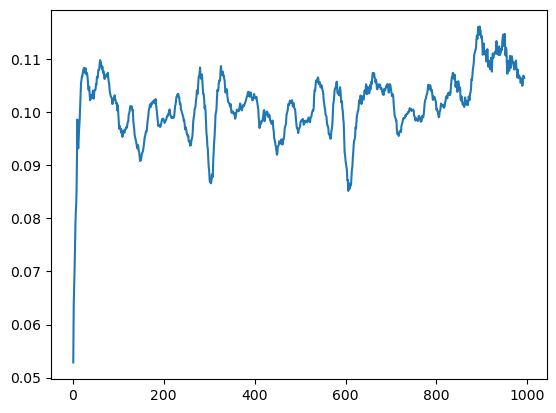

In [7]:
plt.plot(*get_noise_spectrum(oog.delta_phases, 10))


Text(0, 0.5, 'Heartrate')

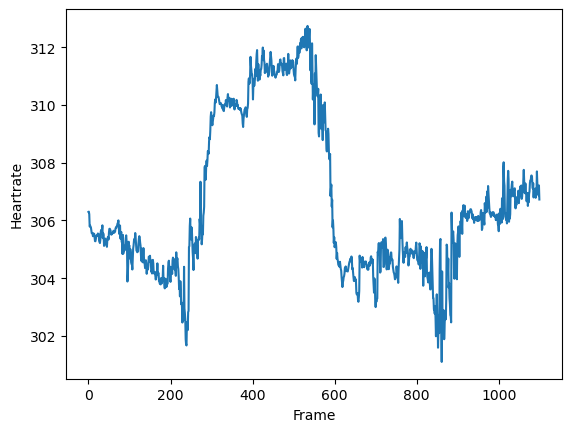

In [13]:
peak_diffs = []
run = True
i = 100
while run == True:
    if i < data.shape[0] - 800:
        sad = -jps.sad_with_references(data[i], data[i+20:i+800])
        sad += np.abs(np.min(sad))
        sad /= np.max(sad)

        peaks, _ = find_peaks(sad, height=0.8, distance = oog.sequence_manager.reference_period / 2)
        if len(peaks) > 0:
            peak1 = peaks[1] + OG.v_fitting(-sad[peaks[1] - 1], -sad[peaks[1]], -sad[peaks[1] + 1])[0]
            peak0 = peaks[0] + OG.v_fitting(-sad[peaks[0] - 1], -sad[peaks[0]], -sad[peaks[0] + 1])[0]
            peak_diff = peak1 - peak0
            peak_diffs.append(peak_diff)
            i += 1
        else:
            run = False
    else:
        run = False

plt.plot(peak_diffs)
plt.xlabel("Frame")
plt.ylabel("Heartrate")

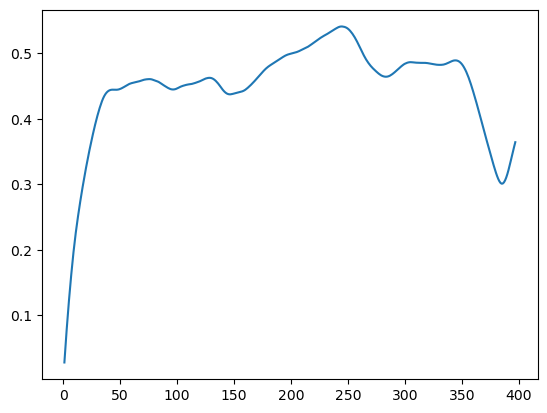

In [ ]:
plt.plot(*get_noise_spectrum(np.array(peak_diffs), 10))

In [ ]:
print(peak_diffs[0])
print(peak_diffs[1])

34.678930288604676
34.72728307988624


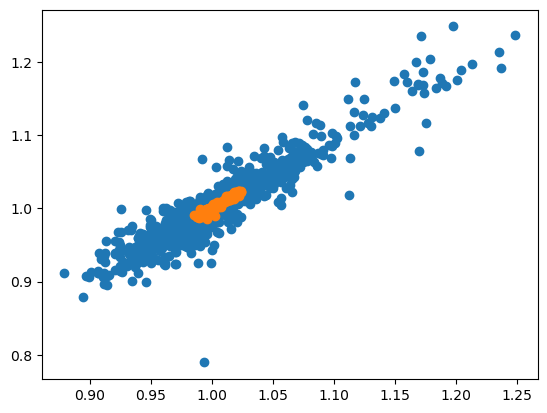

306.61212647352727
305.8603047023309


In [14]:
# Calculate delta_phases moving average
ma = np.convolve(oog.delta_phases, np.ones(40) / 40, mode="valid")

plt.scatter(ma[1::], ma[0:-1])
plt.scatter(np.array(peak_diffs[1::]) / np.mean(peak_diffs[8:48]), np.array(peak_diffs[0:-1]) / np.mean(peak_diffs[8:48]))
plt.show()

print(np.mean(peak_diffs))
print(np.mean(oog.delta_phases * oog.sequence_manager.reference_period))

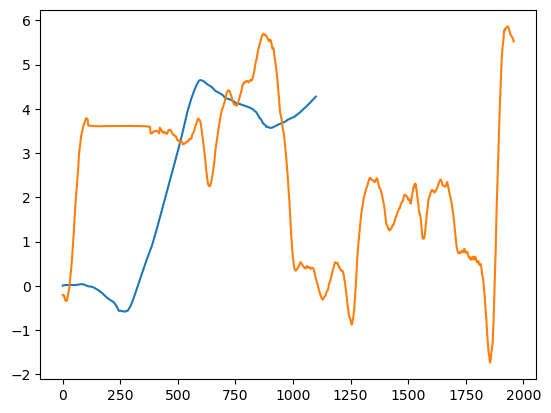

In [15]:
plt.plot(np.cumsum(-1 + peak_diffs / np.mean(peak_diffs[8:48])))
plt.plot(np.cumsum(-1 + ma))

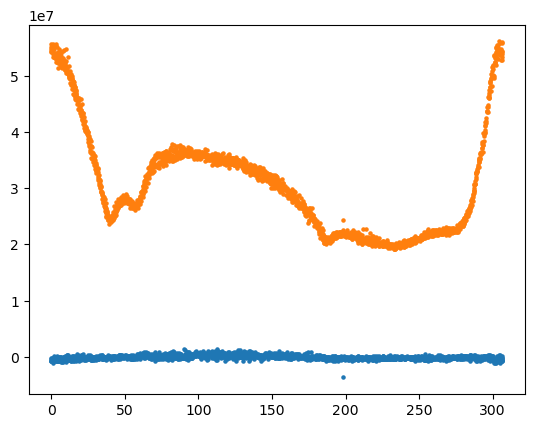

In [23]:
diffs = np.sum((np.diff(data.astype(np.int16), axis=0)), axis=(1, 2))
plt.scatter(oog.phases, diffs, s = 5)
diffs = np.sum((np.abs(np.diff(data.astype(np.int16), axis=0))), axis=(1, 2))
plt.scatter(oog.phases, diffs, s = 5)

plt.show()

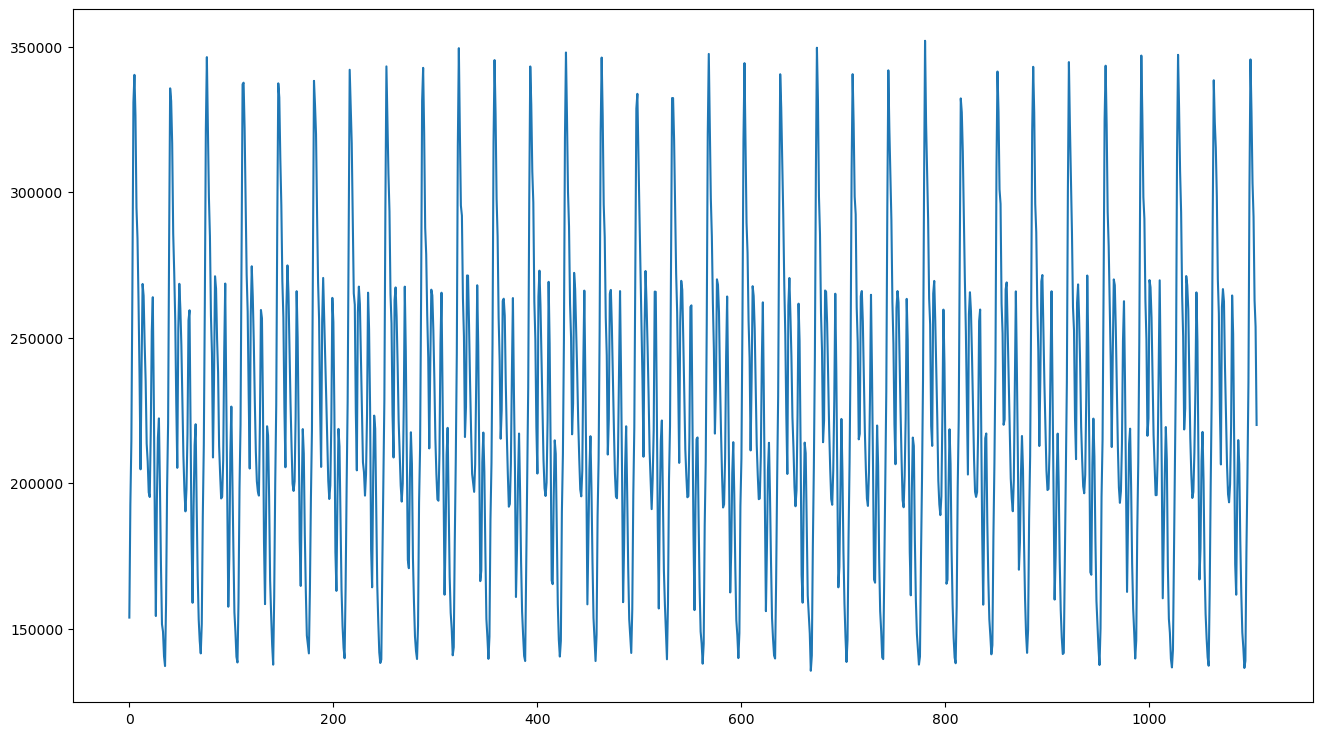

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(diffs)
plt.show()

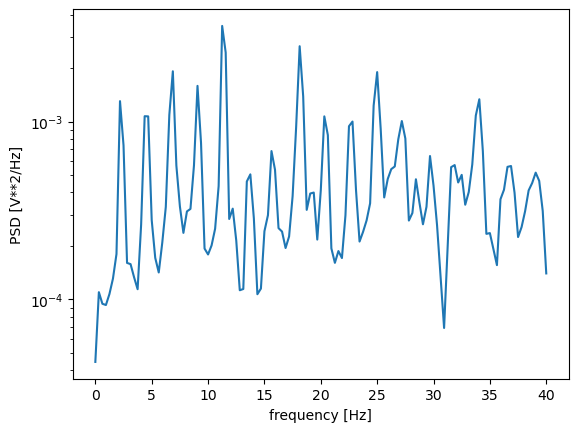

In [ ]:
from scipy import signal
f, Pxx_den = signal.welch(oog.delta_phases, 80, nperseg=256, average = "mean")
plt.semilogy(f, Pxx_den)

plt.xlabel('frequency [Hz]')

plt.ylabel('PSD [V**2/Hz]')

plt.show()

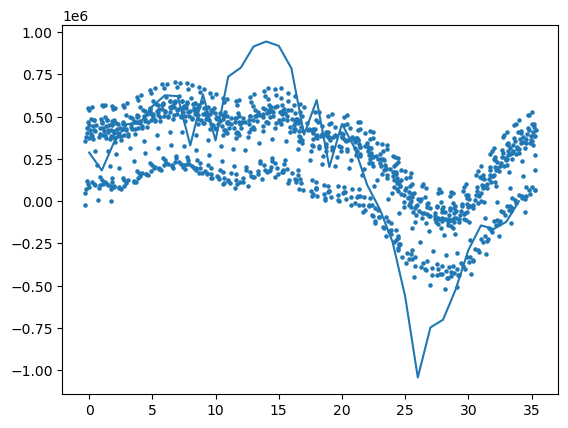

In [ ]:
ref_diffs = np.sum(np.abs(np.diff(oog.sequence_manager.reference_sequence[2:-2], axis=0)), axis=(1, 2))
plt.plot(np.cumsum(ref_diffs - np.mean(ref_diffs)))
plt.scatter(oog.phases, np.cumsum(diffs - np.mean(diffs)), s = 5)

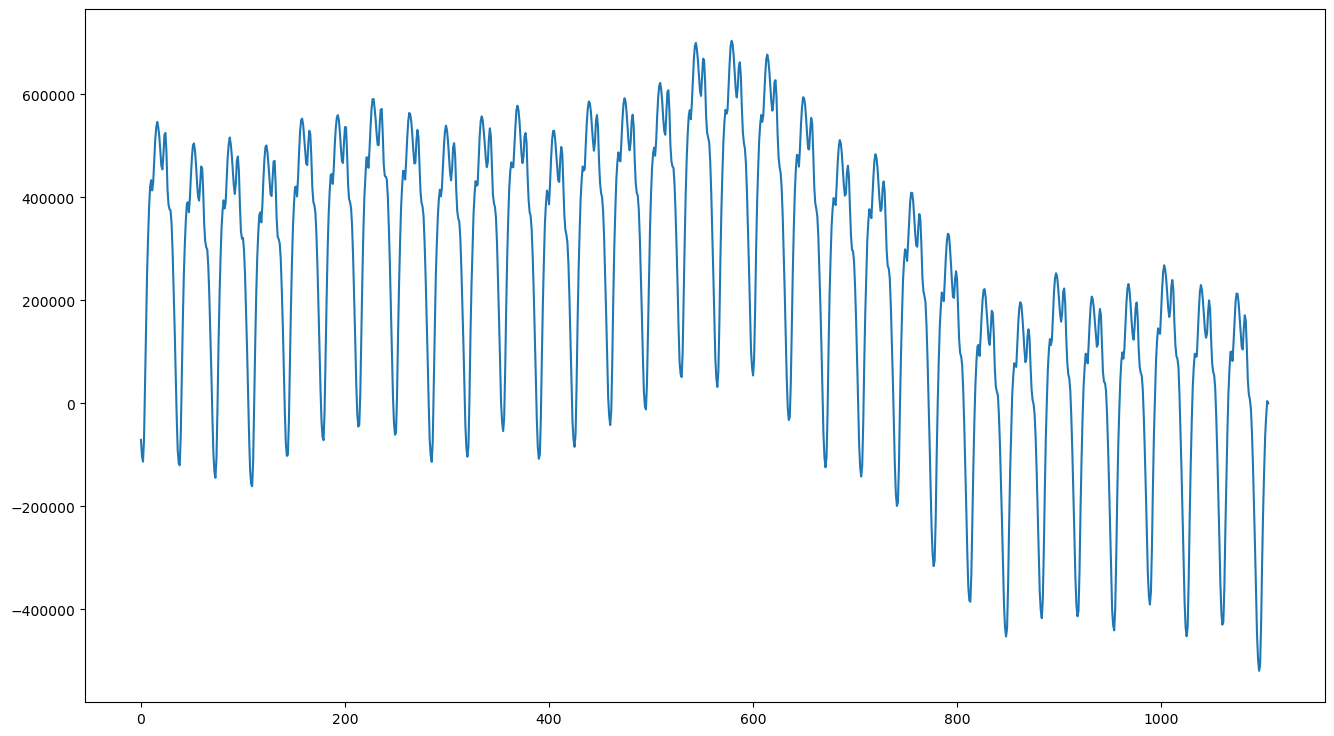

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(np.cumsum(diffs - np.mean(diffs)))
plt.show()

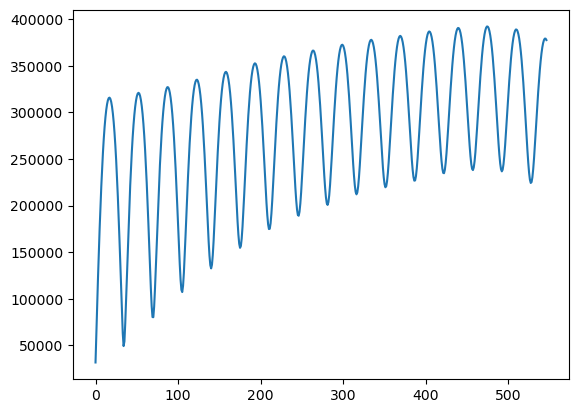

In [ ]:
plt.plot(get_noise_spectrum(np.cumsum(diffs - np.mean(diffs)), 10)[1])

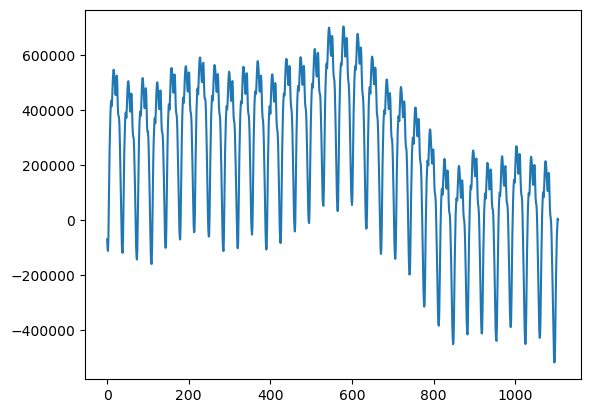

In [ ]:
sad = np.sum(np.abs(np.diff(data.astype(np.int32), axis=0)), axis = (1, 2))

plt.plot(np.cumsum(sad - np.mean(sad)))

In [24]:
data = OG.SequenceManager.load_tif(r"E:\2024-04-09 16.13.55 vid\Allied Vision Technologies GS650 0001f61c\*tif")

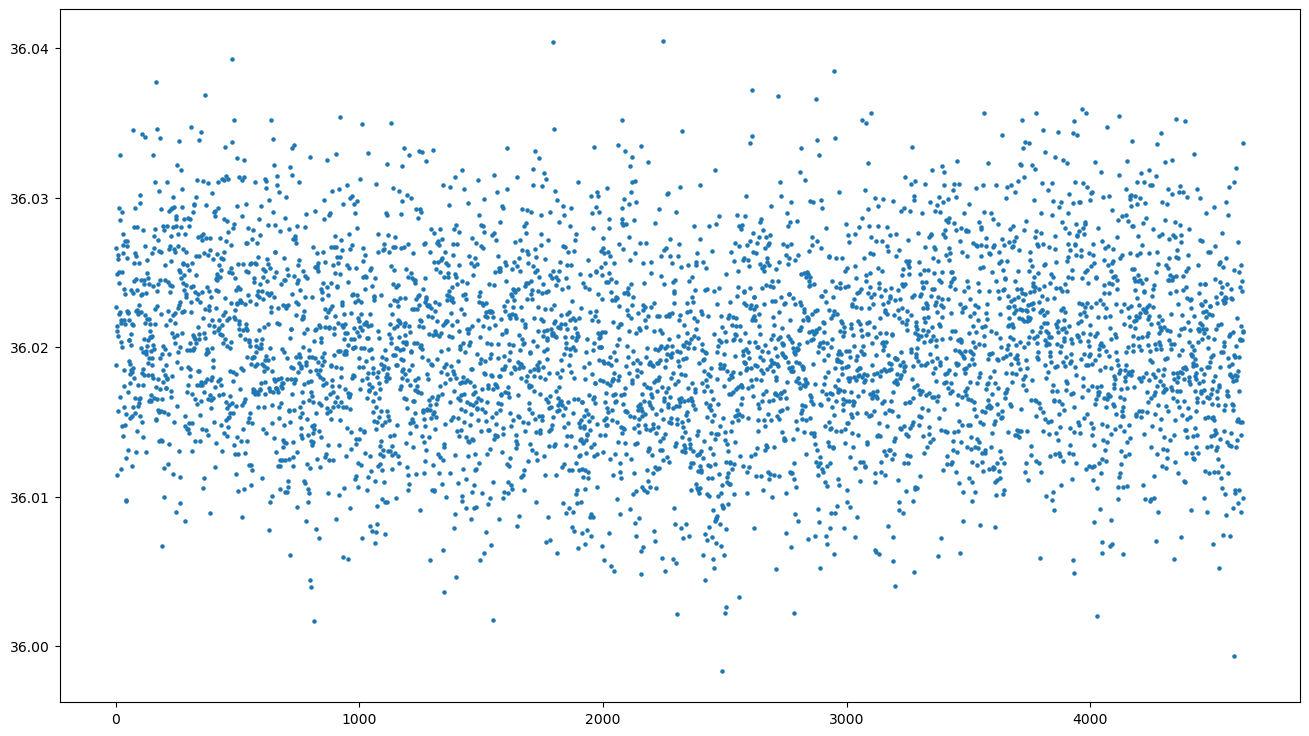

In [27]:
plt.figure(figsize = (16,9))
plt.scatter(range(data.shape[0]), np.mean(data, axis = (1,2)), s = 5)
plt.show()